In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
keras version 2.11.0
tensorflow version 2.11.0


## Importing the dataset

In [2]:
## The location of the Flickr8K_ images
dir_Flickr_jpg = 'archive/images'
## The location of the caption file
dir_Flickr_text = 'archive/captions.txt'



In [3]:
#Finding the captions for each image.
file = open(dir_Flickr_text, "r" ,encoding='utf8')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#") # Splitting the caption dataset at the required position
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())
print(df_txt[:5])


jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs))) 

The number of unique file names : 8092
The distribution of the number of captions for each image:
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  
The number of jpg flies in Flicker8k: 8091


## Plotting few images and their captions from the dataset

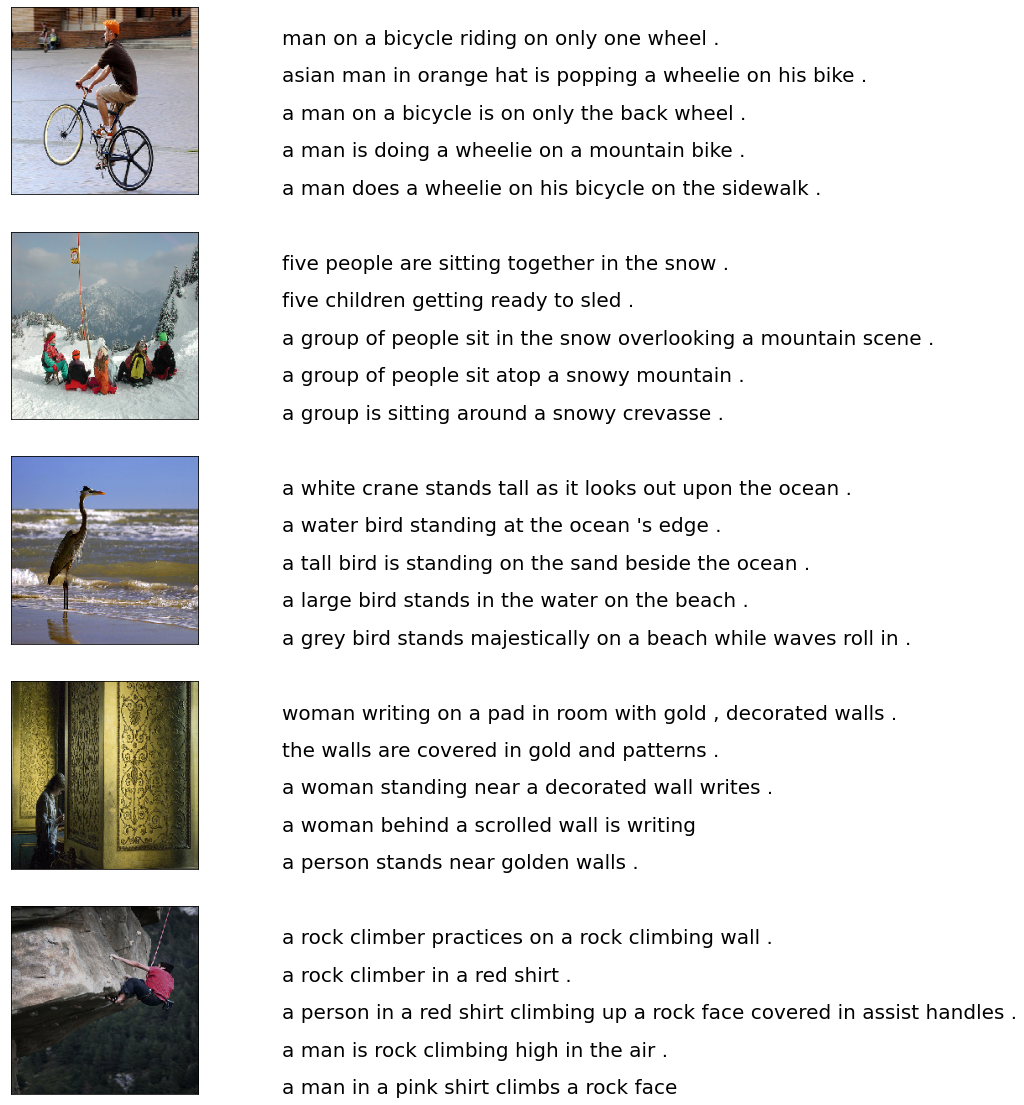

In [4]:
from tensorflow.keras.utils import load_img, img_to_array
from IPython.display import display
from PIL import Image

npic = 5 # Displaying 5 images from the dataset
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-5:]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## Cleaning 

In [5]:
# Defining a function to calculate the top 3 words in all the captions available for the images
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975

In [6]:
import string
text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"

print(text_original)
print("\nRemove punctuations..")
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)
text_no_punctuation = remove_punctuation(text_original)
print(text_no_punctuation)


print("\nRemove a single character word..")
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)
text_len_more_than1 = remove_single_character(text_no_punctuation)
print(text_len_more_than1)

print("\nRemove words with numeric values..")
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)
text_no_numeric = remove_numeric(text_len_more_than1,printTF=True)
print(text_no_numeric)

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Remove punctuations..
I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Remove a single character word..
 ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7

Remove words with numeric values..
    ate        : True
    1000       : False
    apples     : True
    and        : True
    banana     : True
    have       : True
    python     : True
    v27        : False
    Its        : True
    230        : False
    pm         : True
    Could      : True
    you        : True
    buy        : True
    me         : True
    iphone7    : False
 ate apples and banana have python Its pm Could you buy me


In [7]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

Vocabulary Size: 8763


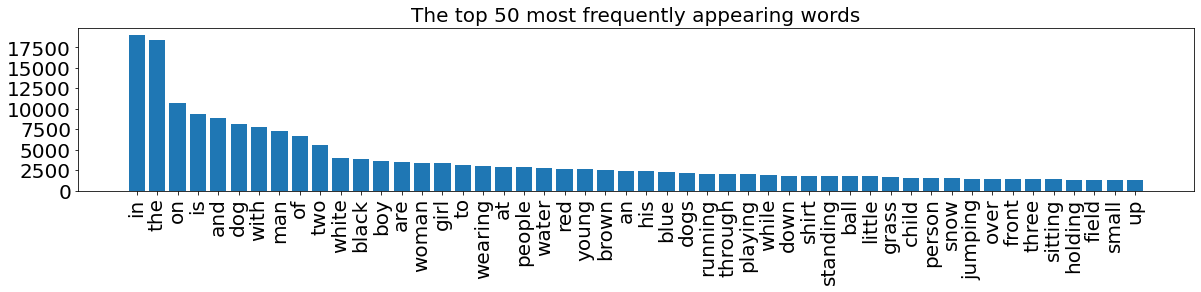

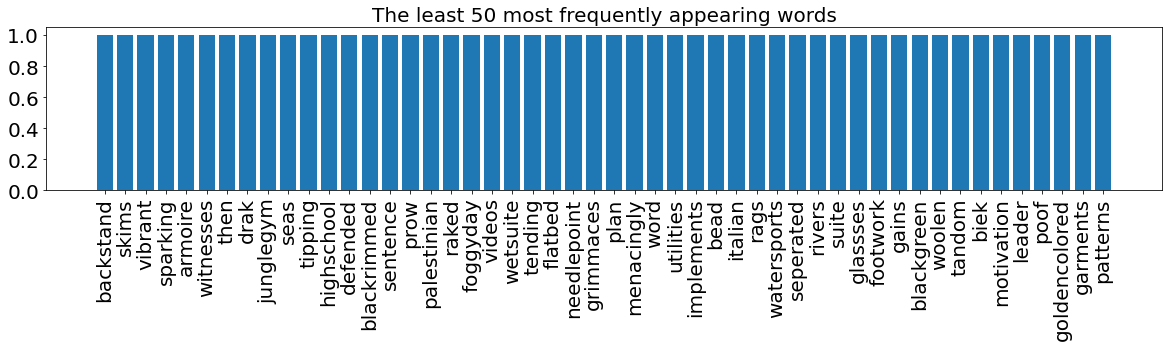

In [8]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

## Preprocessing

In [9]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

In [10]:
df_txt0[:5]

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...

## VGG16 model

In [11]:
from keras.applications import VGG16
#vgg16_weights = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'

modelvgg = VGG16(include_top=True,weights=None )
## load the locally saved weights 
#modelvgg = VGG16(weights=vgg16_weights)
modelvgg.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Deleting the last layer of the model 
The last layer of the VGG-16 is excluded here because we are are just using it for extracting the features rather than using for object classification.

In [12]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Feature extraction

In [13]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224 #image size is fixed at 224 because VGG16 model has been pre-trained to take that size.
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    print(i)
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

0
1/1 [==============================] - 1s 515ms/step
1
1/1 [==============================] - 0s 231ms/step
2
1/1 [==============================] - 0s 165ms/step
3
1/1 [==============================] - 0s 206ms/step
4
1/1 [==============================] - 0s 241ms/step
5
1/1 [==============================] - 0s 222ms/step
6
1/1 [==============================] - 0s 179ms/step
7
1/1 [==============================] - 0s 265ms/step
8
1/1 [==============================] - 0s 237ms/step
9
1/1 [==============================] - 0s 201ms/step
10
1/1 [==============================] - 0s 230ms/step
11
1/1 [==============================] - 0s 209ms/step
12
1/1 [==============================] - 0s 172ms/step
13
1/1 [==============================] - 0s 216ms/step
14
1/1 [==============================] - 0s 169ms/step
15
1/1 [==============================] - 0s 251ms/step
16
1/1 [==============================] - 0s 189ms/step
17
1/1 [==============================] - 0s 254ms/step
18

1/1 [==============================] - 0s 160ms/step
146
1/1 [==============================] - 0s 177ms/step
147
1/1 [==============================] - 0s 170ms/step
148
1/1 [==============================] - 0s 173ms/step
149
1/1 [==============================] - 0s 161ms/step
150
1/1 [==============================] - 0s 163ms/step
151
1/1 [==============================] - 0s 154ms/step
152
1/1 [==============================] - 0s 186ms/step
153
1/1 [==============================] - 0s 163ms/step
154
1/1 [==============================] - 0s 209ms/step
155
1/1 [==============================] - 0s 164ms/step
156
1/1 [==============================] - 0s 191ms/step
157
1/1 [==============================] - 0s 185ms/step
158
1/1 [==============================] - 0s 181ms/step
159
1/1 [==============================] - 0s 169ms/step
160
1/1 [==============================] - 0s 156ms/step
161
1/1 [==============================] - 0s 172ms/step
162
1/1 [==========================

1/1 [==============================] - 0s 183ms/step
289
1/1 [==============================] - 0s 171ms/step
290
1/1 [==============================] - 0s 172ms/step
291
1/1 [==============================] - 0s 178ms/step
292
1/1 [==============================] - 0s 188ms/step
293
1/1 [==============================] - 0s 168ms/step
294
1/1 [==============================] - 0s 192ms/step
295
1/1 [==============================] - 0s 193ms/step
296
1/1 [==============================] - 0s 172ms/step
297
1/1 [==============================] - 0s 167ms/step
298
1/1 [==============================] - 0s 170ms/step
299
1/1 [==============================] - 0s 156ms/step
300
1/1 [==============================] - 0s 191ms/step
301
1/1 [==============================] - 0s 171ms/step
302
1/1 [==============================] - 0s 172ms/step
303
1/1 [==============================] - 0s 160ms/step
304
1/1 [==============================] - 0s 156ms/step
305
1/1 [==========================

1/1 [==============================] - 0s 172ms/step
432
1/1 [==============================] - 0s 197ms/step
433
1/1 [==============================] - 0s 161ms/step
434
1/1 [==============================] - 0s 157ms/step
435
1/1 [==============================] - 0s 185ms/step
436
1/1 [==============================] - 0s 168ms/step
437
1/1 [==============================] - 0s 183ms/step
438
1/1 [==============================] - 0s 185ms/step
439
1/1 [==============================] - 0s 164ms/step
440
1/1 [==============================] - 0s 156ms/step
441
1/1 [==============================] - 0s 157ms/step
442
1/1 [==============================] - 0s 176ms/step
443
1/1 [==============================] - 0s 154ms/step
444
1/1 [==============================] - 0s 160ms/step
445
1/1 [==============================] - 0s 166ms/step
446
1/1 [==============================] - 0s 199ms/step
447
1/1 [==============================] - 0s 294ms/step
448
1/1 [==========================

1/1 [==============================] - 0s 215ms/step
575
1/1 [==============================] - 0s 177ms/step
576
1/1 [==============================] - 0s 263ms/step
577
1/1 [==============================] - 0s 195ms/step
578
1/1 [==============================] - 0s 174ms/step
579
1/1 [==============================] - 0s 156ms/step
580
1/1 [==============================] - 0s 164ms/step
581
1/1 [==============================] - 0s 156ms/step
582
1/1 [==============================] - 0s 174ms/step
583
1/1 [==============================] - 0s 193ms/step
584
1/1 [==============================] - 0s 198ms/step
585
1/1 [==============================] - 0s 247ms/step
586
1/1 [==============================] - 0s 192ms/step
587
1/1 [==============================] - 0s 172ms/step
588
1/1 [==============================] - 0s 166ms/step
589
1/1 [==============================] - 0s 156ms/step
590
1/1 [==============================] - 0s 164ms/step
591
1/1 [==========================

1/1 [==============================] - 0s 175ms/step
718
1/1 [==============================] - 0s 177ms/step
719
1/1 [==============================] - 0s 185ms/step
720
1/1 [==============================] - 0s 166ms/step
721
1/1 [==============================] - 0s 195ms/step
722
1/1 [==============================] - 0s 184ms/step
723
1/1 [==============================] - 0s 164ms/step
724
1/1 [==============================] - 0s 168ms/step
725
1/1 [==============================] - 0s 184ms/step
726
1/1 [==============================] - 0s 184ms/step
727
1/1 [==============================] - 0s 155ms/step
728
1/1 [==============================] - 0s 181ms/step
729
1/1 [==============================] - 0s 155ms/step
730
1/1 [==============================] - 0s 183ms/step
731
1/1 [==============================] - 0s 176ms/step
732
1/1 [==============================] - 0s 178ms/step
733
1/1 [==============================] - 0s 168ms/step
734
1/1 [==========================

1/1 [==============================] - 0s 243ms/step
861
1/1 [==============================] - 0s 250ms/step
862
1/1 [==============================] - 0s 182ms/step
863
1/1 [==============================] - 0s 164ms/step
864
1/1 [==============================] - 0s 165ms/step
865
1/1 [==============================] - 0s 183ms/step
866
1/1 [==============================] - 0s 165ms/step
867
1/1 [==============================] - 0s 200ms/step
868
1/1 [==============================] - 0s 160ms/step
869
1/1 [==============================] - 0s 158ms/step
870
1/1 [==============================] - 0s 163ms/step
871
1/1 [==============================] - 0s 167ms/step
872
1/1 [==============================] - 0s 163ms/step
873
1/1 [==============================] - 0s 189ms/step
874
1/1 [==============================] - 0s 184ms/step
875
1/1 [==============================] - 0s 170ms/step
876
1/1 [==============================] - 0s 169ms/step
877
1/1 [==========================

1/1 [==============================] - 0s 181ms/step
1004
1/1 [==============================] - 0s 182ms/step
1005
1/1 [==============================] - 0s 183ms/step
1006
1/1 [==============================] - 0s 155ms/step
1007
1/1 [==============================] - 0s 184ms/step
1008
1/1 [==============================] - 0s 169ms/step
1009
1/1 [==============================] - 0s 184ms/step
1010
1/1 [==============================] - 0s 251ms/step
1011
1/1 [==============================] - 0s 224ms/step
1012
1/1 [==============================] - 0s 230ms/step
1013
1/1 [==============================] - 0s 201ms/step
1014
1/1 [==============================] - 0s 220ms/step
1015
1/1 [==============================] - 0s 231ms/step
1016
1/1 [==============================] - 0s 199ms/step
1017
1/1 [==============================] - 0s 183ms/step
1018
1/1 [==============================] - 0s 180ms/step
1019
1/1 [==============================] - 0s 176ms/step
1020
1/1 [=========

1/1 [==============================] - 0s 191ms/step
1145
1/1 [==============================] - 0s 182ms/step
1146
1/1 [==============================] - 0s 220ms/step
1147
1/1 [==============================] - 0s 182ms/step
1148
1/1 [==============================] - 0s 184ms/step
1149
1/1 [==============================] - 0s 181ms/step
1150
1/1 [==============================] - 0s 185ms/step
1151
1/1 [==============================] - 0s 193ms/step
1152
1/1 [==============================] - 0s 185ms/step
1153
1/1 [==============================] - 0s 199ms/step
1154
1/1 [==============================] - 0s 166ms/step
1155
1/1 [==============================] - 0s 177ms/step
1156
1/1 [==============================] - 0s 185ms/step
1157
1/1 [==============================] - 0s 179ms/step
1158
1/1 [==============================] - 0s 187ms/step
1159
1/1 [==============================] - 0s 176ms/step
1160
1/1 [==============================] - 0s 215ms/step
1161
1/1 [=========

1/1 [==============================] - 0s 179ms/step
1286
1/1 [==============================] - 0s 220ms/step
1287
1/1 [==============================] - 0s 175ms/step
1288
1/1 [==============================] - 0s 218ms/step
1289
1/1 [==============================] - 0s 177ms/step
1290
1/1 [==============================] - 0s 184ms/step
1291
1/1 [==============================] - 0s 178ms/step
1292
1/1 [==============================] - 0s 168ms/step
1293
1/1 [==============================] - 0s 183ms/step
1294
1/1 [==============================] - 0s 188ms/step
1295
1/1 [==============================] - 0s 165ms/step
1296
1/1 [==============================] - 0s 180ms/step
1297
1/1 [==============================] - 0s 180ms/step
1298
1/1 [==============================] - 0s 188ms/step
1299
1/1 [==============================] - 0s 232ms/step
1300
1/1 [==============================] - 0s 167ms/step
1301
1/1 [==============================] - 0s 199ms/step
1302
1/1 [=========

1/1 [==============================] - 0s 184ms/step
1427
1/1 [==============================] - 0s 178ms/step
1428
1/1 [==============================] - 0s 225ms/step
1429
1/1 [==============================] - 0s 221ms/step
1430
1/1 [==============================] - 0s 199ms/step
1431
1/1 [==============================] - 0s 215ms/step
1432
1/1 [==============================] - 0s 169ms/step
1433
1/1 [==============================] - 0s 175ms/step
1434
1/1 [==============================] - 0s 183ms/step
1435
1/1 [==============================] - 0s 187ms/step
1436
1/1 [==============================] - 0s 217ms/step
1437
1/1 [==============================] - 0s 229ms/step
1438
1/1 [==============================] - 0s 255ms/step
1439
1/1 [==============================] - 0s 167ms/step
1440
1/1 [==============================] - 0s 234ms/step
1441
1/1 [==============================] - 0s 184ms/step
1442
1/1 [==============================] - 0s 169ms/step
1443
1/1 [=========

1/1 [==============================] - 0s 175ms/step
1568
1/1 [==============================] - 0s 161ms/step
1569
1/1 [==============================] - 0s 185ms/step
1570
1/1 [==============================] - 0s 168ms/step
1571
1/1 [==============================] - 0s 258ms/step
1572
1/1 [==============================] - 0s 167ms/step
1573
1/1 [==============================] - 0s 159ms/step
1574
1/1 [==============================] - 0s 161ms/step
1575
1/1 [==============================] - 0s 156ms/step
1576
1/1 [==============================] - 0s 173ms/step
1577
1/1 [==============================] - 0s 188ms/step
1578
1/1 [==============================] - 0s 192ms/step
1579
1/1 [==============================] - 0s 199ms/step
1580
1/1 [==============================] - 0s 195ms/step
1581
1/1 [==============================] - 0s 210ms/step
1582
1/1 [==============================] - 0s 210ms/step
1583
1/1 [==============================] - 0s 225ms/step
1584
1/1 [=========

1/1 [==============================] - 0s 284ms/step
1709
1/1 [==============================] - 0s 246ms/step
1710
1/1 [==============================] - 0s 229ms/step
1711
1/1 [==============================] - 0s 223ms/step
1712
1/1 [==============================] - 0s 188ms/step
1713
1/1 [==============================] - 0s 224ms/step
1714
1/1 [==============================] - 0s 177ms/step
1715
1/1 [==============================] - 0s 193ms/step
1716
1/1 [==============================] - 0s 183ms/step
1717
1/1 [==============================] - 0s 182ms/step
1718
1/1 [==============================] - 0s 189ms/step
1719
1/1 [==============================] - 0s 181ms/step
1720
1/1 [==============================] - 0s 164ms/step
1721
1/1 [==============================] - 0s 166ms/step
1722
1/1 [==============================] - 0s 156ms/step
1723
1/1 [==============================] - 0s 161ms/step
1724
1/1 [==============================] - 0s 162ms/step
1725
1/1 [=========

1/1 [==============================] - 0s 172ms/step
1850
1/1 [==============================] - 0s 193ms/step
1851
1/1 [==============================] - 0s 203ms/step
1852
1/1 [==============================] - 0s 174ms/step
1853
1/1 [==============================] - 0s 167ms/step
1854
1/1 [==============================] - 0s 173ms/step
1855
1/1 [==============================] - 0s 166ms/step
1856
1/1 [==============================] - 0s 155ms/step
1857
1/1 [==============================] - 0s 161ms/step
1858
1/1 [==============================] - 0s 169ms/step
1859
1/1 [==============================] - 0s 207ms/step
1860
1/1 [==============================] - 0s 179ms/step
1861
1/1 [==============================] - 0s 173ms/step
1862
1/1 [==============================] - 0s 202ms/step
1863
1/1 [==============================] - 0s 246ms/step
1864
1/1 [==============================] - 0s 207ms/step
1865
1/1 [==============================] - 0s 178ms/step
1866
1/1 [=========

1/1 [==============================] - 0s 161ms/step
1991
1/1 [==============================] - 0s 235ms/step
1992
1/1 [==============================] - 0s 296ms/step
1993
1/1 [==============================] - 0s 209ms/step
1994
1/1 [==============================] - 0s 252ms/step
1995
1/1 [==============================] - 0s 265ms/step
1996
1/1 [==============================] - 0s 177ms/step
1997
1/1 [==============================] - 0s 174ms/step
1998
1/1 [==============================] - 0s 241ms/step
1999
1/1 [==============================] - 0s 210ms/step
2000
1/1 [==============================] - 0s 187ms/step
2001
1/1 [==============================] - 0s 258ms/step
2002
1/1 [==============================] - 0s 225ms/step
2003
1/1 [==============================] - 0s 259ms/step
2004
1/1 [==============================] - 0s 210ms/step
2005
1/1 [==============================] - 0s 174ms/step
2006
1/1 [==============================] - 0s 260ms/step
2007
1/1 [=========

1/1 [==============================] - 0s 200ms/step
2132
1/1 [==============================] - 0s 176ms/step
2133
1/1 [==============================] - 0s 180ms/step
2134
1/1 [==============================] - 0s 251ms/step
2135
1/1 [==============================] - 0s 171ms/step
2136
1/1 [==============================] - 0s 200ms/step
2137
1/1 [==============================] - 0s 179ms/step
2138
1/1 [==============================] - 0s 226ms/step
2139
1/1 [==============================] - 0s 184ms/step
2140
1/1 [==============================] - 0s 189ms/step
2141
1/1 [==============================] - 0s 191ms/step
2142
1/1 [==============================] - 0s 185ms/step
2143
1/1 [==============================] - 0s 191ms/step
2144
1/1 [==============================] - 0s 199ms/step
2145
1/1 [==============================] - 0s 193ms/step
2146
1/1 [==============================] - 0s 193ms/step
2147
1/1 [==============================] - 0s 192ms/step
2148
1/1 [=========

1/1 [==============================] - 0s 195ms/step
2273
1/1 [==============================] - 0s 232ms/step
2274
1/1 [==============================] - 0s 244ms/step
2275
1/1 [==============================] - 0s 182ms/step
2276
1/1 [==============================] - 0s 175ms/step
2277
1/1 [==============================] - 0s 191ms/step
2278
1/1 [==============================] - 0s 168ms/step
2279
1/1 [==============================] - 0s 182ms/step
2280
1/1 [==============================] - 0s 180ms/step
2281
1/1 [==============================] - 0s 221ms/step
2282
1/1 [==============================] - 0s 166ms/step
2283
1/1 [==============================] - 0s 257ms/step
2284
1/1 [==============================] - 0s 175ms/step
2285
1/1 [==============================] - 0s 200ms/step
2286
1/1 [==============================] - 0s 176ms/step
2287
1/1 [==============================] - 0s 183ms/step
2288
1/1 [==============================] - 0s 167ms/step
2289
1/1 [=========

1/1 [==============================] - 0s 184ms/step
2414
1/1 [==============================] - 0s 185ms/step
2415
1/1 [==============================] - 0s 184ms/step
2416
1/1 [==============================] - 0s 183ms/step
2417
1/1 [==============================] - 0s 183ms/step
2418
1/1 [==============================] - 0s 191ms/step
2419
1/1 [==============================] - 0s 193ms/step
2420
1/1 [==============================] - 0s 193ms/step
2421
1/1 [==============================] - 0s 184ms/step
2422
1/1 [==============================] - 0s 177ms/step
2423
1/1 [==============================] - 0s 216ms/step
2424
1/1 [==============================] - 0s 185ms/step
2425
1/1 [==============================] - 0s 183ms/step
2426
1/1 [==============================] - 0s 168ms/step
2427
1/1 [==============================] - 0s 199ms/step
2428
1/1 [==============================] - 0s 183ms/step
2429
1/1 [==============================] - 0s 173ms/step
2430
1/1 [=========

1/1 [==============================] - 0s 168ms/step
2555
1/1 [==============================] - 0s 183ms/step
2556
1/1 [==============================] - 0s 216ms/step
2557
1/1 [==============================] - 0s 176ms/step
2558
1/1 [==============================] - 0s 182ms/step
2559
1/1 [==============================] - 0s 178ms/step
2560
1/1 [==============================] - 0s 185ms/step
2561
1/1 [==============================] - 0s 184ms/step
2562
1/1 [==============================] - 0s 194ms/step
2563
1/1 [==============================] - 0s 197ms/step
2564
1/1 [==============================] - 0s 197ms/step
2565
1/1 [==============================] - 0s 189ms/step
2566
1/1 [==============================] - 0s 232ms/step
2567
1/1 [==============================] - 0s 200ms/step
2568
1/1 [==============================] - 0s 188ms/step
2569
1/1 [==============================] - 0s 183ms/step
2570
1/1 [==============================] - 0s 184ms/step
2571
1/1 [=========

1/1 [==============================] - 0s 186ms/step
2696
1/1 [==============================] - 0s 198ms/step
2697
1/1 [==============================] - 0s 175ms/step
2698
1/1 [==============================] - 0s 203ms/step
2699
1/1 [==============================] - 0s 210ms/step
2700
1/1 [==============================] - 0s 203ms/step
2701
1/1 [==============================] - 0s 249ms/step
2702
1/1 [==============================] - 0s 200ms/step
2703
1/1 [==============================] - 0s 209ms/step
2704
1/1 [==============================] - 0s 235ms/step
2705
1/1 [==============================] - 0s 216ms/step
2706
1/1 [==============================] - 0s 239ms/step
2707
1/1 [==============================] - 0s 208ms/step
2708
1/1 [==============================] - 0s 194ms/step
2709
1/1 [==============================] - 0s 192ms/step
2710
1/1 [==============================] - 0s 200ms/step
2711
1/1 [==============================] - 0s 185ms/step
2712
1/1 [=========

1/1 [==============================] - 0s 211ms/step
2837
1/1 [==============================] - 0s 217ms/step
2838
1/1 [==============================] - 0s 201ms/step
2839
1/1 [==============================] - 0s 184ms/step
2840
1/1 [==============================] - 0s 255ms/step
2841
1/1 [==============================] - 0s 200ms/step
2842
1/1 [==============================] - 0s 187ms/step
2843
1/1 [==============================] - 0s 184ms/step
2844
1/1 [==============================] - 0s 183ms/step
2845
1/1 [==============================] - 0s 201ms/step
2846
1/1 [==============================] - 0s 184ms/step
2847
1/1 [==============================] - 0s 180ms/step
2848
1/1 [==============================] - 0s 200ms/step
2849
1/1 [==============================] - 0s 214ms/step
2850
1/1 [==============================] - 0s 178ms/step
2851
1/1 [==============================] - 0s 232ms/step
2852
1/1 [==============================] - 0s 183ms/step
2853
1/1 [=========

1/1 [==============================] - 0s 237ms/step
2978
1/1 [==============================] - 0s 186ms/step
2979
1/1 [==============================] - 0s 261ms/step
2980
1/1 [==============================] - 0s 170ms/step
2981
1/1 [==============================] - 0s 183ms/step
2982
1/1 [==============================] - 0s 185ms/step
2983
1/1 [==============================] - 0s 200ms/step
2984
1/1 [==============================] - 0s 201ms/step
2985
1/1 [==============================] - 0s 183ms/step
2986
1/1 [==============================] - 0s 208ms/step
2987
1/1 [==============================] - 0s 183ms/step
2988
1/1 [==============================] - 0s 200ms/step
2989
1/1 [==============================] - 0s 192ms/step
2990
1/1 [==============================] - 0s 200ms/step
2991
1/1 [==============================] - 0s 176ms/step
2992
1/1 [==============================] - 0s 184ms/step
2993
1/1 [==============================] - 0s 209ms/step
2994
1/1 [=========

1/1 [==============================] - 0s 195ms/step
3119
1/1 [==============================] - 0s 212ms/step
3120
1/1 [==============================] - 0s 215ms/step
3121
1/1 [==============================] - 0s 191ms/step
3122
1/1 [==============================] - 0s 214ms/step
3123
1/1 [==============================] - 0s 209ms/step
3124
1/1 [==============================] - 0s 217ms/step
3125
1/1 [==============================] - 0s 193ms/step
3126
1/1 [==============================] - 0s 211ms/step
3127
1/1 [==============================] - 0s 249ms/step
3128
1/1 [==============================] - 0s 237ms/step
3129
1/1 [==============================] - 0s 196ms/step
3130
1/1 [==============================] - 0s 189ms/step
3131
1/1 [==============================] - 0s 193ms/step
3132
1/1 [==============================] - 0s 198ms/step
3133
1/1 [==============================] - 0s 191ms/step
3134
1/1 [==============================] - 0s 199ms/step
3135
1/1 [=========

1/1 [==============================] - 0s 206ms/step
3260
1/1 [==============================] - 0s 232ms/step
3261
1/1 [==============================] - 0s 238ms/step
3262
1/1 [==============================] - 0s 191ms/step
3263
1/1 [==============================] - 0s 195ms/step
3264
1/1 [==============================] - 0s 194ms/step
3265
1/1 [==============================] - 0s 204ms/step
3266
1/1 [==============================] - 0s 197ms/step
3267
1/1 [==============================] - 0s 214ms/step
3268
1/1 [==============================] - 0s 197ms/step
3269
1/1 [==============================] - 0s 182ms/step
3270
1/1 [==============================] - 0s 201ms/step
3271
1/1 [==============================] - 0s 235ms/step
3272
1/1 [==============================] - 0s 201ms/step
3273
1/1 [==============================] - 0s 219ms/step
3274
1/1 [==============================] - 0s 218ms/step
3275
1/1 [==============================] - 0s 200ms/step
3276
1/1 [=========

1/1 [==============================] - 0s 219ms/step
3401
1/1 [==============================] - 0s 210ms/step
3402
1/1 [==============================] - 0s 208ms/step
3403
1/1 [==============================] - 0s 220ms/step
3404
1/1 [==============================] - 0s 202ms/step
3405
1/1 [==============================] - 0s 217ms/step
3406
1/1 [==============================] - 0s 232ms/step
3407
1/1 [==============================] - 0s 214ms/step
3408
1/1 [==============================] - 0s 215ms/step
3409
1/1 [==============================] - 0s 202ms/step
3410
1/1 [==============================] - 0s 188ms/step
3411
1/1 [==============================] - 0s 195ms/step
3412
1/1 [==============================] - 0s 237ms/step
3413
1/1 [==============================] - 0s 196ms/step
3414
1/1 [==============================] - 0s 208ms/step
3415
1/1 [==============================] - 0s 218ms/step
3416
1/1 [==============================] - 0s 192ms/step
3417
1/1 [=========

1/1 [==============================] - 0s 245ms/step
3542
1/1 [==============================] - 0s 264ms/step
3543
1/1 [==============================] - 0s 231ms/step
3544
1/1 [==============================] - 0s 266ms/step
3545
1/1 [==============================] - 0s 248ms/step
3546
1/1 [==============================] - 0s 240ms/step
3547
1/1 [==============================] - 0s 250ms/step
3548
1/1 [==============================] - 0s 248ms/step
3549
1/1 [==============================] - 0s 270ms/step
3550
1/1 [==============================] - 0s 235ms/step
3551
1/1 [==============================] - 0s 259ms/step
3552
1/1 [==============================] - 0s 339ms/step
3553
1/1 [==============================] - 0s 314ms/step
3554
1/1 [==============================] - 0s 280ms/step
3555
1/1 [==============================] - 0s 281ms/step
3556
1/1 [==============================] - 0s 275ms/step
3557
1/1 [==============================] - 0s 301ms/step
3558
1/1 [=========

1/1 [==============================] - 0s 280ms/step
3683
1/1 [==============================] - 0s 327ms/step
3684
1/1 [==============================] - 0s 314ms/step
3685
1/1 [==============================] - 0s 262ms/step
3686
1/1 [==============================] - 0s 264ms/step
3687
1/1 [==============================] - 0s 289ms/step
3688
1/1 [==============================] - 0s 275ms/step
3689
1/1 [==============================] - 0s 314ms/step
3690
1/1 [==============================] - 0s 262ms/step
3691
1/1 [==============================] - 0s 268ms/step
3692
1/1 [==============================] - 0s 268ms/step
3693
1/1 [==============================] - 0s 313ms/step
3694
1/1 [==============================] - 0s 274ms/step
3695
1/1 [==============================] - 0s 312ms/step
3696
1/1 [==============================] - 0s 314ms/step
3697
1/1 [==============================] - 0s 305ms/step
3698
1/1 [==============================] - 0s 340ms/step
3699
1/1 [=========

1/1 [==============================] - 0s 236ms/step
3824
1/1 [==============================] - 0s 279ms/step
3825
1/1 [==============================] - 0s 266ms/step
3826
1/1 [==============================] - 0s 282ms/step
3827
1/1 [==============================] - 0s 317ms/step
3828
1/1 [==============================] - 0s 289ms/step
3829
1/1 [==============================] - 0s 266ms/step
3830
1/1 [==============================] - 0s 284ms/step
3831
1/1 [==============================] - 0s 286ms/step
3832
1/1 [==============================] - 0s 282ms/step
3833
1/1 [==============================] - 0s 328ms/step
3834
1/1 [==============================] - 0s 317ms/step
3835
1/1 [==============================] - 0s 315ms/step
3836
1/1 [==============================] - 0s 350ms/step
3837
1/1 [==============================] - 0s 304ms/step
3838
1/1 [==============================] - 0s 305ms/step
3839
1/1 [==============================] - 0s 275ms/step
3840
1/1 [=========

1/1 [==============================] - 0s 299ms/step
3965
1/1 [==============================] - 0s 328ms/step
3966
1/1 [==============================] - 0s 284ms/step
3967
1/1 [==============================] - 0s 326ms/step
3968
1/1 [==============================] - 0s 366ms/step
3969
1/1 [==============================] - 0s 330ms/step
3970
1/1 [==============================] - 0s 312ms/step
3971
1/1 [==============================] - 0s 316ms/step
3972
1/1 [==============================] - 0s 319ms/step
3973
1/1 [==============================] - 0s 279ms/step
3974
1/1 [==============================] - 0s 319ms/step
3975
1/1 [==============================] - 0s 297ms/step
3976
1/1 [==============================] - 0s 329ms/step
3977
1/1 [==============================] - 0s 324ms/step
3978
1/1 [==============================] - 0s 316ms/step
3979
1/1 [==============================] - 0s 302ms/step
3980
1/1 [==============================] - 0s 282ms/step
3981
1/1 [=========

1/1 [==============================] - 0s 298ms/step
4106
1/1 [==============================] - 0s 346ms/step
4107
1/1 [==============================] - 0s 301ms/step
4108
1/1 [==============================] - 0s 343ms/step
4109
1/1 [==============================] - 0s 308ms/step
4110
1/1 [==============================] - 0s 303ms/step
4111
1/1 [==============================] - 0s 264ms/step
4112
1/1 [==============================] - 0s 297ms/step
4113
1/1 [==============================] - 0s 287ms/step
4114
1/1 [==============================] - 0s 295ms/step
4115
1/1 [==============================] - 0s 317ms/step
4116
1/1 [==============================] - 0s 279ms/step
4117
1/1 [==============================] - 0s 276ms/step
4118
1/1 [==============================] - 0s 323ms/step
4119
1/1 [==============================] - 0s 303ms/step
4120
1/1 [==============================] - 0s 284ms/step
4121
1/1 [==============================] - 0s 322ms/step
4122
1/1 [=========

1/1 [==============================] - 0s 304ms/step
4247
1/1 [==============================] - 0s 309ms/step
4248
1/1 [==============================] - 0s 303ms/step
4249
1/1 [==============================] - 0s 322ms/step
4250
1/1 [==============================] - 0s 323ms/step
4251
1/1 [==============================] - 0s 326ms/step
4252
1/1 [==============================] - 0s 297ms/step
4253
1/1 [==============================] - 0s 339ms/step
4254
1/1 [==============================] - 0s 300ms/step
4255
1/1 [==============================] - 0s 296ms/step
4256
1/1 [==============================] - 0s 330ms/step
4257
1/1 [==============================] - 0s 347ms/step
4258
1/1 [==============================] - 0s 312ms/step
4259
1/1 [==============================] - 0s 325ms/step
4260
1/1 [==============================] - 0s 296ms/step
4261
1/1 [==============================] - 0s 400ms/step
4262
1/1 [==============================] - 0s 297ms/step
4263
1/1 [=========

1/1 [==============================] - 0s 295ms/step
4388
1/1 [==============================] - 0s 319ms/step
4389
1/1 [==============================] - 0s 357ms/step
4390
1/1 [==============================] - 0s 367ms/step
4391
1/1 [==============================] - 0s 308ms/step
4392
1/1 [==============================] - 0s 368ms/step
4393
1/1 [==============================] - 0s 371ms/step
4394
1/1 [==============================] - 0s 407ms/step
4395
1/1 [==============================] - 0s 339ms/step
4396
1/1 [==============================] - 0s 302ms/step
4397
1/1 [==============================] - 0s 377ms/step
4398
1/1 [==============================] - 0s 311ms/step
4399
1/1 [==============================] - 0s 313ms/step
4400
1/1 [==============================] - 0s 311ms/step
4401
1/1 [==============================] - 0s 328ms/step
4402
1/1 [==============================] - 0s 316ms/step
4403
1/1 [==============================] - 0s 311ms/step
4404
1/1 [=========

1/1 [==============================] - 0s 294ms/step
4529
1/1 [==============================] - 0s 312ms/step
4530
1/1 [==============================] - 0s 417ms/step
4531
1/1 [==============================] - 0s 372ms/step
4532
1/1 [==============================] - 0s 324ms/step
4533
1/1 [==============================] - 0s 305ms/step
4534
1/1 [==============================] - 0s 310ms/step
4535
1/1 [==============================] - 0s 328ms/step
4536
1/1 [==============================] - 0s 310ms/step
4537
1/1 [==============================] - 0s 289ms/step
4538
1/1 [==============================] - 0s 299ms/step
4539
1/1 [==============================] - 0s 311ms/step
4540
1/1 [==============================] - 0s 316ms/step
4541
1/1 [==============================] - 1s 556ms/step
4542
1/1 [==============================] - 0s 294ms/step
4543
1/1 [==============================] - 0s 303ms/step
4544
1/1 [==============================] - 0s 275ms/step
4545
1/1 [=========

1/1 [==============================] - 0s 360ms/step
4670
1/1 [==============================] - 0s 377ms/step
4671
1/1 [==============================] - 0s 378ms/step
4672
1/1 [==============================] - 0s 399ms/step
4673
1/1 [==============================] - 0s 391ms/step
4674
1/1 [==============================] - 0s 341ms/step
4675
1/1 [==============================] - 0s 345ms/step
4676
1/1 [==============================] - 0s 329ms/step
4677
1/1 [==============================] - 0s 334ms/step
4678
1/1 [==============================] - 1s 532ms/step
4679
1/1 [==============================] - 0s 336ms/step
4680
1/1 [==============================] - 0s 303ms/step
4681
1/1 [==============================] - 0s 393ms/step
4682
1/1 [==============================] - 0s 302ms/step
4683
1/1 [==============================] - 0s 310ms/step
4684
1/1 [==============================] - 0s 317ms/step
4685
1/1 [==============================] - 0s 447ms/step
4686
1/1 [=========

1/1 [==============================] - 0s 433ms/step
4811
1/1 [==============================] - 0s 364ms/step
4812
1/1 [==============================] - 0s 361ms/step
4813
1/1 [==============================] - 0s 354ms/step
4814
1/1 [==============================] - 0s 356ms/step
4815
1/1 [==============================] - 0s 423ms/step
4816
1/1 [==============================] - 0s 428ms/step
4817
1/1 [==============================] - 0s 478ms/step
4818
1/1 [==============================] - 0s 358ms/step
4819
1/1 [==============================] - 0s 344ms/step
4820
1/1 [==============================] - 0s 352ms/step
4821
1/1 [==============================] - 0s 360ms/step
4822
1/1 [==============================] - 0s 413ms/step
4823
1/1 [==============================] - 0s 463ms/step
4824
1/1 [==============================] - 0s 343ms/step
4825
1/1 [==============================] - 0s 356ms/step
4826
1/1 [==============================] - 0s 380ms/step
4827
1/1 [=========

1/1 [==============================] - 0s 421ms/step
4952
1/1 [==============================] - 0s 332ms/step
4953
1/1 [==============================] - 0s 342ms/step
4954
1/1 [==============================] - 0s 431ms/step
4955
1/1 [==============================] - 1s 528ms/step
4956
1/1 [==============================] - 0s 330ms/step
4957
1/1 [==============================] - 0s 346ms/step
4958
1/1 [==============================] - 0s 314ms/step
4959
1/1 [==============================] - 0s 327ms/step
4960
1/1 [==============================] - 0s 309ms/step
4961
1/1 [==============================] - 0s 416ms/step
4962
1/1 [==============================] - 1s 529ms/step
4963
1/1 [==============================] - 0s 344ms/step
4964
1/1 [==============================] - 0s 348ms/step
4965
1/1 [==============================] - 0s 345ms/step
4966
1/1 [==============================] - 0s 328ms/step
4967
1/1 [==============================] - 0s 342ms/step
4968
1/1 [=========

1/1 [==============================] - 0s 339ms/step
5093
1/1 [==============================] - 0s 418ms/step
5094
1/1 [==============================] - 0s 315ms/step
5095
1/1 [==============================] - 0s 346ms/step
5096
1/1 [==============================] - 0s 321ms/step
5097
1/1 [==============================] - 0s 405ms/step
5098
1/1 [==============================] - 0s 328ms/step
5099
1/1 [==============================] - 0s 329ms/step
5100
1/1 [==============================] - 0s 335ms/step
5101
1/1 [==============================] - 0s 347ms/step
5102
1/1 [==============================] - 0s 331ms/step
5103
1/1 [==============================] - 0s 334ms/step
5104
1/1 [==============================] - 0s 323ms/step
5105
1/1 [==============================] - 0s 312ms/step
5106
1/1 [==============================] - 0s 345ms/step
5107
1/1 [==============================] - 0s 326ms/step
5108
1/1 [==============================] - 0s 335ms/step
5109
1/1 [=========

1/1 [==============================] - 0s 398ms/step
5234
1/1 [==============================] - 0s 422ms/step
5235
1/1 [==============================] - 0s 375ms/step
5236
1/1 [==============================] - 0s 376ms/step
5237
1/1 [==============================] - 0s 471ms/step
5238
1/1 [==============================] - 0s 356ms/step
5239
1/1 [==============================] - 0s 362ms/step
5240
1/1 [==============================] - 0s 377ms/step
5241
1/1 [==============================] - 0s 377ms/step
5242
1/1 [==============================] - 0s 376ms/step
5243
1/1 [==============================] - 0s 474ms/step
5244
1/1 [==============================] - 0s 368ms/step
5245
1/1 [==============================] - 0s 430ms/step
5246
1/1 [==============================] - 0s 347ms/step
5247
1/1 [==============================] - 0s 356ms/step
5248
1/1 [==============================] - 0s 357ms/step
5249
1/1 [==============================] - 0s 391ms/step
5250
1/1 [=========

1/1 [==============================] - 0s 386ms/step
5375
1/1 [==============================] - 0s 354ms/step
5376
1/1 [==============================] - 0s 358ms/step
5377
1/1 [==============================] - 0s 367ms/step
5378
1/1 [==============================] - 0s 331ms/step
5379
1/1 [==============================] - 0s 356ms/step
5380
1/1 [==============================] - 0s 359ms/step
5381
1/1 [==============================] - 0s 342ms/step
5382
1/1 [==============================] - 0s 363ms/step
5383
1/1 [==============================] - 0s 446ms/step
5384
1/1 [==============================] - 0s 340ms/step
5385
1/1 [==============================] - 0s 435ms/step
5386
1/1 [==============================] - 0s 361ms/step
5387
1/1 [==============================] - 0s 368ms/step
5388
1/1 [==============================] - 0s 317ms/step
5389
1/1 [==============================] - 0s 351ms/step
5390
1/1 [==============================] - 0s 318ms/step
5391
1/1 [=========

1/1 [==============================] - 0s 404ms/step
5516
1/1 [==============================] - 1s 562ms/step
5517
1/1 [==============================] - 0s 403ms/step
5518
1/1 [==============================] - 1s 515ms/step
5519
1/1 [==============================] - 0s 456ms/step
5520
1/1 [==============================] - 0s 363ms/step
5521
1/1 [==============================] - 0s 362ms/step
5522
1/1 [==============================] - 0s 378ms/step
5523
1/1 [==============================] - 0s 383ms/step
5524
1/1 [==============================] - 0s 378ms/step
5525
1/1 [==============================] - 1s 696ms/step
5526
1/1 [==============================] - 0s 374ms/step
5527
1/1 [==============================] - 0s 420ms/step
5528
1/1 [==============================] - 0s 379ms/step
5529
1/1 [==============================] - 0s 468ms/step
5530
1/1 [==============================] - 0s 487ms/step
5531
1/1 [==============================] - 0s 343ms/step
5532
1/1 [=========

1/1 [==============================] - 0s 363ms/step
5657
1/1 [==============================] - 0s 412ms/step
5658
1/1 [==============================] - 1s 553ms/step
5659
1/1 [==============================] - 0s 452ms/step
5660
1/1 [==============================] - 0s 465ms/step
5661
1/1 [==============================] - 0s 444ms/step
5662
1/1 [==============================] - 0s 372ms/step
5663
1/1 [==============================] - 0s 466ms/step
5664
1/1 [==============================] - 0s 354ms/step
5665
1/1 [==============================] - 0s 372ms/step
5666
1/1 [==============================] - 0s 343ms/step
5667
1/1 [==============================] - 0s 346ms/step
5668
1/1 [==============================] - 0s 437ms/step
5669
1/1 [==============================] - 0s 350ms/step
5670
1/1 [==============================] - 0s 461ms/step
5671
1/1 [==============================] - 0s 493ms/step
5672
1/1 [==============================] - 0s 366ms/step
5673
1/1 [=========

1/1 [==============================] - 0s 490ms/step
5798
1/1 [==============================] - 0s 442ms/step
5799
1/1 [==============================] - 0s 413ms/step
5800
1/1 [==============================] - 1s 566ms/step
5801
1/1 [==============================] - 0s 474ms/step
5802
1/1 [==============================] - 0s 421ms/step
5803
1/1 [==============================] - 1s 585ms/step
5804
1/1 [==============================] - 0s 406ms/step
5805
1/1 [==============================] - 1s 527ms/step
5806
1/1 [==============================] - 1s 657ms/step
5807
1/1 [==============================] - 0s 413ms/step
5808
1/1 [==============================] - 0s 393ms/step
5809
1/1 [==============================] - 0s 401ms/step
5810
1/1 [==============================] - 0s 406ms/step
5811
1/1 [==============================] - 0s 409ms/step
5812
1/1 [==============================] - 0s 395ms/step
5813
1/1 [==============================] - 0s 400ms/step
5814
1/1 [=========

1/1 [==============================] - 0s 477ms/step
5939
1/1 [==============================] - 0s 413ms/step
5940
1/1 [==============================] - 0s 344ms/step
5941
1/1 [==============================] - 0s 343ms/step
5942
1/1 [==============================] - 0s 428ms/step
5943
1/1 [==============================] - 0s 416ms/step
5944
1/1 [==============================] - 0s 381ms/step
5945
1/1 [==============================] - 0s 436ms/step
5946
1/1 [==============================] - 0s 412ms/step
5947
1/1 [==============================] - 0s 347ms/step
5948
1/1 [==============================] - 0s 396ms/step
5949
1/1 [==============================] - 1s 547ms/step
5950
1/1 [==============================] - 0s 407ms/step
5951
1/1 [==============================] - 0s 481ms/step
5952
1/1 [==============================] - 0s 377ms/step
5953
1/1 [==============================] - 1s 623ms/step
5954
1/1 [==============================] - 0s 391ms/step
5955
1/1 [=========

1/1 [==============================] - 0s 398ms/step
6080
1/1 [==============================] - 0s 391ms/step
6081
1/1 [==============================] - 0s 389ms/step
6082
1/1 [==============================] - 0s 403ms/step
6083
1/1 [==============================] - 0s 475ms/step
6084
1/1 [==============================] - 0s 427ms/step
6085
1/1 [==============================] - 0s 414ms/step
6086
1/1 [==============================] - 0s 414ms/step
6087
1/1 [==============================] - 0s 396ms/step
6088
1/1 [==============================] - 0s 391ms/step
6089
1/1 [==============================] - 0s 484ms/step
6090
1/1 [==============================] - 0s 406ms/step
6091
1/1 [==============================] - 0s 476ms/step
6092
1/1 [==============================] - 0s 397ms/step
6093
1/1 [==============================] - 0s 361ms/step
6094
1/1 [==============================] - 1s 575ms/step
6095
1/1 [==============================] - 0s 362ms/step
6096
1/1 [=========

1/1 [==============================] - 1s 525ms/step
6221
1/1 [==============================] - 0s 429ms/step
6222
1/1 [==============================] - 0s 446ms/step
6223
1/1 [==============================] - 0s 407ms/step
6224
1/1 [==============================] - 0s 437ms/step
6225
1/1 [==============================] - 0s 487ms/step
6226
1/1 [==============================] - 0s 476ms/step
6227
1/1 [==============================] - 0s 437ms/step
6228
1/1 [==============================] - 0s 424ms/step
6229
1/1 [==============================] - 0s 489ms/step
6230
1/1 [==============================] - 0s 428ms/step
6231
1/1 [==============================] - 0s 424ms/step
6232
1/1 [==============================] - 1s 537ms/step
6233
1/1 [==============================] - 0s 450ms/step
6234
1/1 [==============================] - 0s 414ms/step
6235
1/1 [==============================] - 0s 414ms/step
6236
1/1 [==============================] - 1s 562ms/step
6237
1/1 [=========

1/1 [==============================] - 0s 381ms/step
6362
1/1 [==============================] - 1s 506ms/step
6363
1/1 [==============================] - 0s 424ms/step
6364
1/1 [==============================] - 1s 586ms/step
6365
1/1 [==============================] - 0s 412ms/step
6366
1/1 [==============================] - 1s 516ms/step
6367
1/1 [==============================] - 0s 472ms/step
6368
1/1 [==============================] - 0s 447ms/step
6369
1/1 [==============================] - 1s 515ms/step
6370
1/1 [==============================] - 0s 437ms/step
6371
1/1 [==============================] - 1s 639ms/step
6372
1/1 [==============================] - 1s 560ms/step
6373
1/1 [==============================] - 1s 549ms/step
6374
1/1 [==============================] - 1s 562ms/step
6375
1/1 [==============================] - 0s 476ms/step
6376
1/1 [==============================] - 1s 742ms/step
6377
1/1 [==============================] - 1s 508ms/step
6378
1/1 [=========

1/1 [==============================] - 0s 432ms/step
6503
1/1 [==============================] - 0s 435ms/step
6504
1/1 [==============================] - 1s 563ms/step
6505
1/1 [==============================] - 0s 415ms/step
6506
1/1 [==============================] - 1s 542ms/step
6507
1/1 [==============================] - 0s 426ms/step
6508
1/1 [==============================] - 0s 496ms/step
6509
1/1 [==============================] - 0s 425ms/step
6510
1/1 [==============================] - 1s 516ms/step
6511
1/1 [==============================] - 0s 379ms/step
6512
1/1 [==============================] - 0s 456ms/step
6513
1/1 [==============================] - 0s 400ms/step
6514
1/1 [==============================] - 0s 415ms/step
6515
1/1 [==============================] - 1s 559ms/step
6516
1/1 [==============================] - 1s 538ms/step
6517
1/1 [==============================] - 1s 519ms/step
6518
1/1 [==============================] - 0s 427ms/step
6519
1/1 [=========

1/1 [==============================] - 0s 480ms/step
6644
1/1 [==============================] - 1s 531ms/step
6645
1/1 [==============================] - 1s 560ms/step
6646
1/1 [==============================] - 1s 528ms/step
6647
1/1 [==============================] - 0s 450ms/step
6648
1/1 [==============================] - 1s 553ms/step
6649
1/1 [==============================] - 0s 462ms/step
6650
1/1 [==============================] - 1s 592ms/step
6651
1/1 [==============================] - 0s 469ms/step
6652
1/1 [==============================] - 0s 447ms/step
6653
1/1 [==============================] - 0s 457ms/step
6654
1/1 [==============================] - 1s 630ms/step
6655
1/1 [==============================] - 1s 538ms/step
6656
1/1 [==============================] - 0s 460ms/step
6657
1/1 [==============================] - 1s 577ms/step
6658
1/1 [==============================] - 1s 593ms/step
6659
1/1 [==============================] - 1s 550ms/step
6660
1/1 [=========

1/1 [==============================] - 1s 522ms/step
6785
1/1 [==============================] - 1s 757ms/step
6786
1/1 [==============================] - 1s 556ms/step
6787
1/1 [==============================] - 1s 530ms/step
6788
1/1 [==============================] - 1s 547ms/step
6789
1/1 [==============================] - 1s 574ms/step
6790
1/1 [==============================] - 1s 650ms/step
6791
1/1 [==============================] - 1s 574ms/step
6792
1/1 [==============================] - 1s 563ms/step
6793
1/1 [==============================] - 1s 660ms/step
6794
1/1 [==============================] - 1s 507ms/step
6795
1/1 [==============================] - 1s 595ms/step
6796
1/1 [==============================] - 1s 694ms/step
6797
1/1 [==============================] - 1s 606ms/step
6798
1/1 [==============================] - 1s 524ms/step
6799
1/1 [==============================] - 1s 510ms/step
6800
1/1 [==============================] - 1s 631ms/step
6801
1/1 [=========

1/1 [==============================] - 0s 431ms/step
6926
1/1 [==============================] - 0s 421ms/step
6927
1/1 [==============================] - 1s 634ms/step
6928
1/1 [==============================] - 0s 447ms/step
6929
1/1 [==============================] - 1s 528ms/step
6930
1/1 [==============================] - 0s 463ms/step
6931
1/1 [==============================] - 1s 502ms/step
6932
1/1 [==============================] - 0s 430ms/step
6933
1/1 [==============================] - 1s 541ms/step
6934
1/1 [==============================] - 0s 436ms/step
6935
1/1 [==============================] - 1s 525ms/step
6936
1/1 [==============================] - 0s 442ms/step
6937
1/1 [==============================] - 1s 585ms/step
6938
1/1 [==============================] - 1s 529ms/step
6939
1/1 [==============================] - 1s 531ms/step
6940
1/1 [==============================] - 0s 438ms/step
6941
1/1 [==============================] - 1s 553ms/step
6942
1/1 [=========

1/1 [==============================] - 0s 455ms/step
7067
1/1 [==============================] - 0s 445ms/step
7068
1/1 [==============================] - 1s 537ms/step
7069
1/1 [==============================] - 0s 421ms/step
7070
1/1 [==============================] - 0s 482ms/step
7071
1/1 [==============================] - 1s 503ms/step
7072
1/1 [==============================] - 0s 408ms/step
7073
1/1 [==============================] - 0s 455ms/step
7074
1/1 [==============================] - 1s 615ms/step
7075
1/1 [==============================] - 1s 596ms/step
7076
1/1 [==============================] - 0s 488ms/step
7077
1/1 [==============================] - 0s 478ms/step
7078
1/1 [==============================] - 0s 463ms/step
7079
1/1 [==============================] - 0s 457ms/step
7080
1/1 [==============================] - 1s 540ms/step
7081
1/1 [==============================] - 0s 465ms/step
7082
1/1 [==============================] - 1s 635ms/step
7083
1/1 [=========

1/1 [==============================] - 1s 584ms/step
7208
1/1 [==============================] - 0s 460ms/step
7209
1/1 [==============================] - 0s 500ms/step
7210
1/1 [==============================] - 0s 498ms/step
7211
1/1 [==============================] - 1s 653ms/step
7212
1/1 [==============================] - 0s 475ms/step
7213
1/1 [==============================] - 1s 721ms/step
7214
1/1 [==============================] - 1s 527ms/step
7215
1/1 [==============================] - 1s 593ms/step
7216
1/1 [==============================] - 1s 570ms/step
7217
1/1 [==============================] - 1s 668ms/step
7218
1/1 [==============================] - 1s 633ms/step
7219
1/1 [==============================] - 1s 687ms/step
7220
1/1 [==============================] - 1s 517ms/step
7221
1/1 [==============================] - 1s 669ms/step
7222
1/1 [==============================] - 1s 512ms/step
7223
1/1 [==============================] - 1s 622ms/step
7224
1/1 [=========

1/1 [==============================] - 1s 597ms/step
7349
1/1 [==============================] - 1s 599ms/step
7350
1/1 [==============================] - 1s 630ms/step
7351
1/1 [==============================] - 1s 601ms/step
7352
1/1 [==============================] - 1s 590ms/step
7353
1/1 [==============================] - 1s 546ms/step
7354
1/1 [==============================] - 1s 541ms/step
7355
1/1 [==============================] - 1s 531ms/step
7356
1/1 [==============================] - 1s 523ms/step
7357
1/1 [==============================] - 0s 500ms/step
7358
1/1 [==============================] - 0s 430ms/step
7359
1/1 [==============================] - 1s 608ms/step
7360
1/1 [==============================] - 1s 660ms/step
7361
1/1 [==============================] - 1s 524ms/step
7362
1/1 [==============================] - 1s 523ms/step
7363
1/1 [==============================] - 1s 566ms/step
7364
1/1 [==============================] - 1s 530ms/step
7365
1/1 [=========

1/1 [==============================] - 1s 559ms/step
7490
1/1 [==============================] - 1s 531ms/step
7491
1/1 [==============================] - 1s 617ms/step
7492
1/1 [==============================] - 1s 551ms/step
7493
1/1 [==============================] - 1s 552ms/step
7494
1/1 [==============================] - 1s 556ms/step
7495
1/1 [==============================] - 1s 569ms/step
7496
1/1 [==============================] - 1s 563ms/step
7497
1/1 [==============================] - 1s 570ms/step
7498
1/1 [==============================] - 1s 533ms/step
7499
1/1 [==============================] - 1s 610ms/step
7500
1/1 [==============================] - 1s 517ms/step
7501
1/1 [==============================] - 1s 534ms/step
7502
1/1 [==============================] - 1s 526ms/step
7503
1/1 [==============================] - 1s 578ms/step
7504
1/1 [==============================] - 1s 598ms/step
7505
1/1 [==============================] - 1s 517ms/step
7506
1/1 [=========

1/1 [==============================] - 1s 585ms/step
7631
1/1 [==============================] - 1s 578ms/step
7632
1/1 [==============================] - 1s 589ms/step
7633
1/1 [==============================] - 1s 585ms/step
7634
1/1 [==============================] - 1s 593ms/step
7635
1/1 [==============================] - 1s 584ms/step
7636
1/1 [==============================] - 1s 615ms/step
7637
1/1 [==============================] - 1s 631ms/step
7638
1/1 [==============================] - 1s 667ms/step
7639
1/1 [==============================] - 1s 618ms/step
7640
1/1 [==============================] - 1s 604ms/step
7641
1/1 [==============================] - 1s 632ms/step
7642
1/1 [==============================] - 1s 591ms/step
7643
1/1 [==============================] - 1s 592ms/step
7644
1/1 [==============================] - 1s 595ms/step
7645
1/1 [==============================] - 1s 585ms/step
7646
1/1 [==============================] - 1s 572ms/step
7647
1/1 [=========

1/1 [==============================] - 1s 618ms/step
7772
1/1 [==============================] - 1s 609ms/step
7773
1/1 [==============================] - 1s 617ms/step
7774
1/1 [==============================] - 1s 613ms/step
7775
1/1 [==============================] - 1s 595ms/step
7776
1/1 [==============================] - 1s 619ms/step
7777
1/1 [==============================] - 1s 593ms/step
7778
1/1 [==============================] - 1s 617ms/step
7779
1/1 [==============================] - 1s 579ms/step
7780
1/1 [==============================] - 1s 634ms/step
7781
1/1 [==============================] - 1s 611ms/step
7782
1/1 [==============================] - 1s 615ms/step
7783
1/1 [==============================] - 1s 626ms/step
7784
1/1 [==============================] - 1s 651ms/step
7785
1/1 [==============================] - 1s 618ms/step
7786
1/1 [==============================] - 1s 624ms/step
7787
1/1 [==============================] - 1s 598ms/step
7788
1/1 [=========

1/1 [==============================] - 1s 617ms/step
7913
1/1 [==============================] - 1s 598ms/step
7914
1/1 [==============================] - 1s 552ms/step
7915
1/1 [==============================] - 1s 642ms/step
7916
1/1 [==============================] - 1s 569ms/step
7917
1/1 [==============================] - 1s 507ms/step
7918
1/1 [==============================] - 1s 608ms/step
7919
1/1 [==============================] - 1s 646ms/step
7920
1/1 [==============================] - 1s 600ms/step
7921
1/1 [==============================] - 1s 558ms/step
7922
1/1 [==============================] - 1s 611ms/step
7923
1/1 [==============================] - 1s 647ms/step
7924
1/1 [==============================] - 1s 590ms/step
7925
1/1 [==============================] - 1s 615ms/step
7926
1/1 [==============================] - 1s 608ms/step
7927
1/1 [==============================] - 1s 559ms/step
7928
1/1 [==============================] - 1s 669ms/step
7929
1/1 [=========

1/1 [==============================] - 1s 650ms/step
8054
1/1 [==============================] - 1s 603ms/step
8055
1/1 [==============================] - 1s 627ms/step
8056
1/1 [==============================] - 1s 648ms/step
8057
1/1 [==============================] - 1s 615ms/step
8058
1/1 [==============================] - 1s 614ms/step
8059
1/1 [==============================] - 1s 601ms/step
8060
1/1 [==============================] - 1s 651ms/step
8061
1/1 [==============================] - 1s 570ms/step
8062
1/1 [==============================] - 1s 611ms/step
8063
1/1 [==============================] - 1s 610ms/step
8064
1/1 [==============================] - 1s 557ms/step
8065
1/1 [==============================] - 1s 622ms/step
8066
1/1 [==============================] - 1s 600ms/step
8067
1/1 [==============================] - 1s 634ms/step
8068
1/1 [==============================] - 1s 740ms/step
8069
1/1 [==============================] - 1s 730ms/step
8070
1/1 [=========

## Plotting similar images

In [14]:
from sklearn.decomposition import PCA

encoder = np.array(list(images.values()))
#print(encoder)
pca = PCA(n_components=2)
#print(pca)
y_pca = pca.fit_transform(encoder)

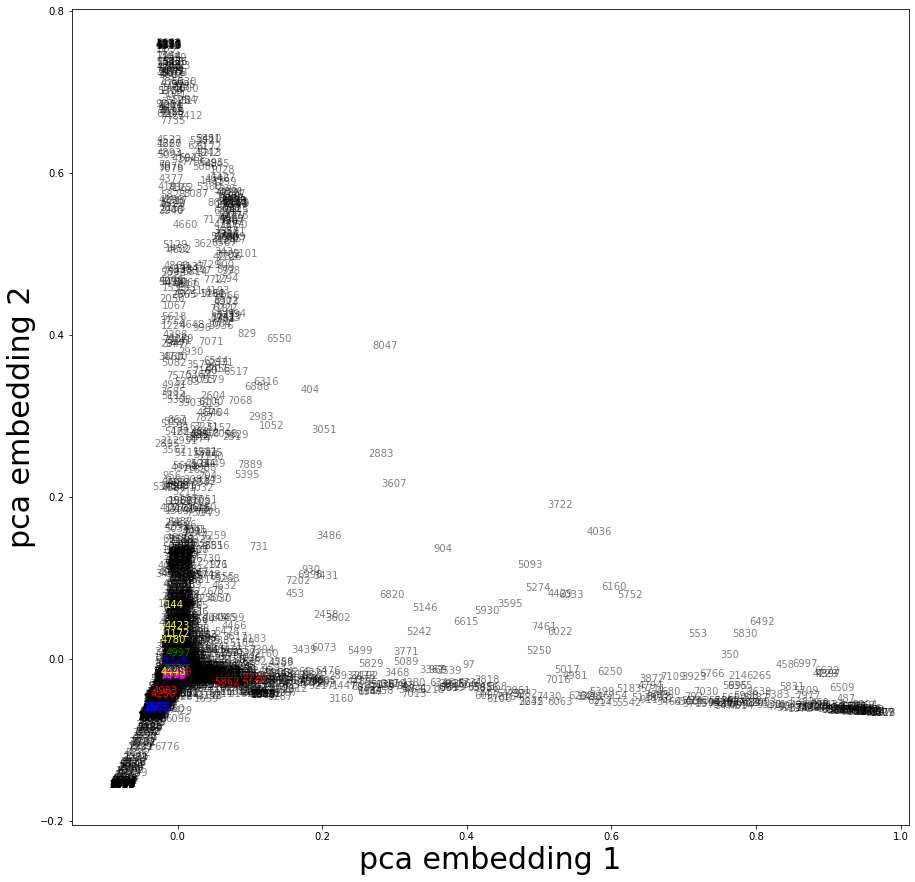

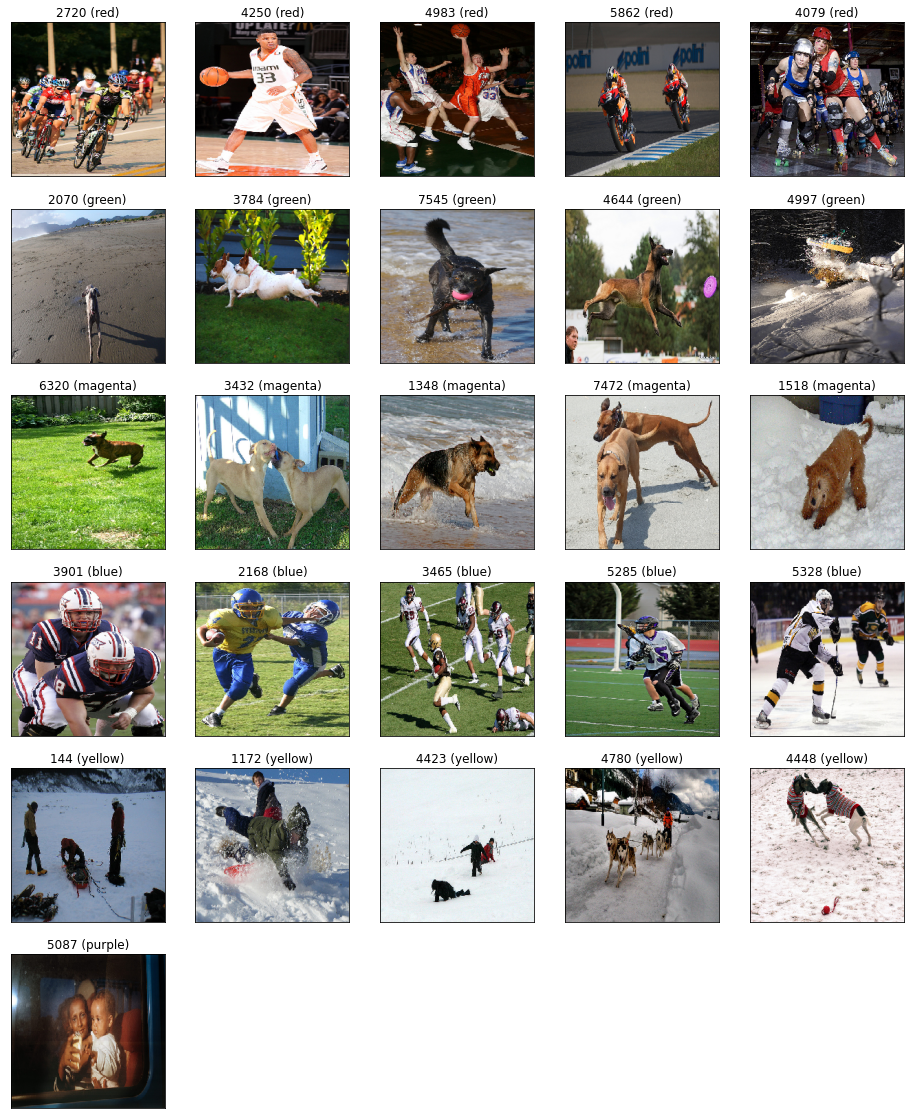

In [15]:
## some selected pictures that are creating clusters
#these are just to display the related images from the dataset
picked_pic = OrderedDict()
picked_pic["red"]     = [2720,4250,4983,5862,4079]
picked_pic["green"]   = [2070,3784,7545,4644, 4997]
picked_pic["magenta"] = [6320,3432,1348,7472, 1518]
picked_pic["blue"]    = [3901,2168,3465,5285,5328]
picked_pic["yellow"]  = [144,1172,4423,4780,4448]
picked_pic["purple"]  = [5087]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5) #annotate() is used to place text at the location of the point
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()


## plot of images 
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

In [16]:
dimages, keepindex = [],[]
# Creating a datframe where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

#fnames are the names of the image files        
fnames = df_txt0["filename"].iloc[keepindex].values
#dcaptions are the captions of the images 
dcaptions = df_txt0["caption"].iloc[keepindex].values
#dimages are the actual features of the images
dimages = np.array(dimages)

In [17]:
df_txt0[:5]

filename index  \
0   1000268201_693b08cb0e.jpg     0   
5   1001773457_577c3a7d70.jpg     0   
10  1002674143_1b742ab4b8.jpg     0   
15  1003163366_44323f5815.jpg     0   
20  1007129816_e794419615.jpg     0   

                                              caption  
0   startseq  child in pink dress is climbing up s...  
5   startseq  black dog and spotted dog are fighti...  
10  startseq  little girl covered in paint sits in...  
15  startseq  man lays on bench while his dog sits...  
20  startseq  man in an orange hat starring at som...

## Tokenizing the captions

In [18]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [19]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [20]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


In [23]:
#from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages)) # using assert to make sure that length of images and captions are always similar
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):
        # zip() is used to create a tuple of iteratable items
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()# using pad sequence to make the length of all captions equal
            out_text = to_categorical(out_text,num_classes = vocab_size) # using to_categorical to 

            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 4855
 (49631, 30) (49631, 1000) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 1000) (16353, 4476)


# LSTM model

In [24]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import LeakyReLU, PReLU
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature",return_sequences=True)(ftxt)
#,return_sequences=True
#,activation='relu'
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256,name="CaptionFeature2")(se2)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_3[0][0]']                
                                                                                                  
 CaptionFeature (LSTM)          (None, 30, 256)      328704      ['embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 30, 256)      0           ['CaptionFeature[0][0]']         
                                                                                       

In [25]:
# fit model
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
#start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=6, verbose=2, 
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),callbacks=[tensorboard])
#end = time.time()
#print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/6
1551/1551 - 3717s - loss: 5.3693 - val_loss: 4.8580 - 3717s/epoch - 2s/step
Epoch 2/6
1551/1551 - 2409s - loss: 4.5301 - val_loss: 4.5614 - 2409s/epoch - 2s/step
Epoch 3/6
1551/1551 - 2385s - loss: 4.1431 - val_loss: 4.4617 - 2385s/epoch - 2s/step
Epoch 4/6
1551/1551 - 2354s - loss: 3.8571 - val_loss: 4.4580 - 2354s/epoch - 2s/step
Epoch 5/6
1551/1551 - 2363s - loss: 3.6336 - val_loss: 4.4921 - 2363s/epoch - 2s/step
Epoch 6/6
1551/1551 - 2405s - loss: 3.4401 - val_loss: 4.5648 - 2405s/epoch - 2s/step


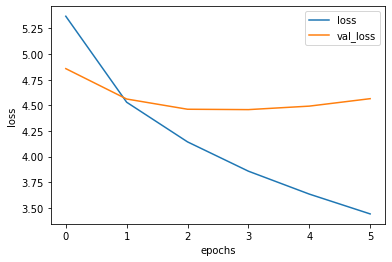

In [26]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predicting captions

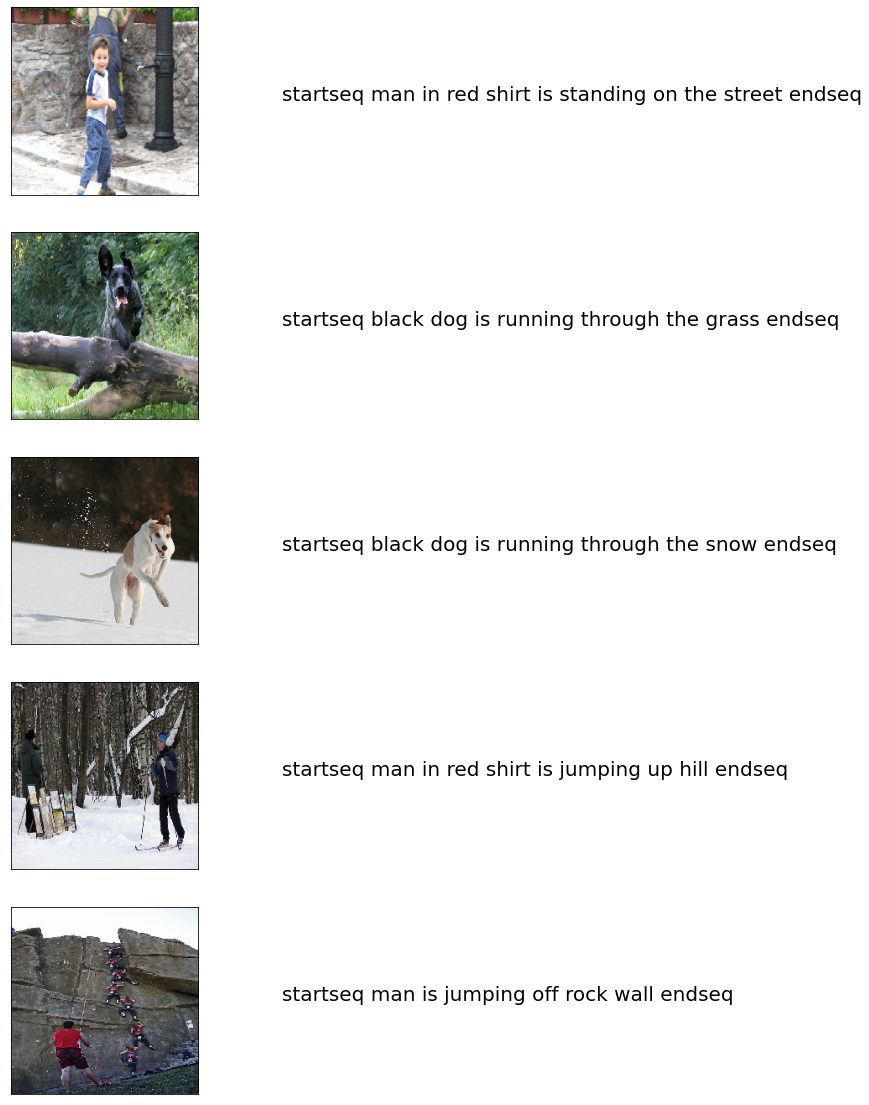

In [27]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    ## images 
    filename = dir_Flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

# Calculating bleu score

In [28]:
import nltk

*GOOD EXAMPLE*

In [29]:
true='dog is running in snow'
pred='dog is running through the snow'
reference=list(true.split())
hypothesis=list(pred.split())
nltk.translate.bleu_score.sentence_bleu([reference],hypothesis,weights = (0.5, 0.5))

0.5163977794943222

*BAD EXAMPLE*

In [30]:
true='man is walking sking in the snow'
pred='man in red shirt is riding up up the hill'
reference=list(true.split())
hypothesis=list(pred.split())
nltk.translate.bleu_score.sentence_bleu([reference],hypothesis,weights = (0.5, 0.5))

9.434137710479516e-155

In [42]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = nltk.translate.bleu_score.sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


Bad Caption


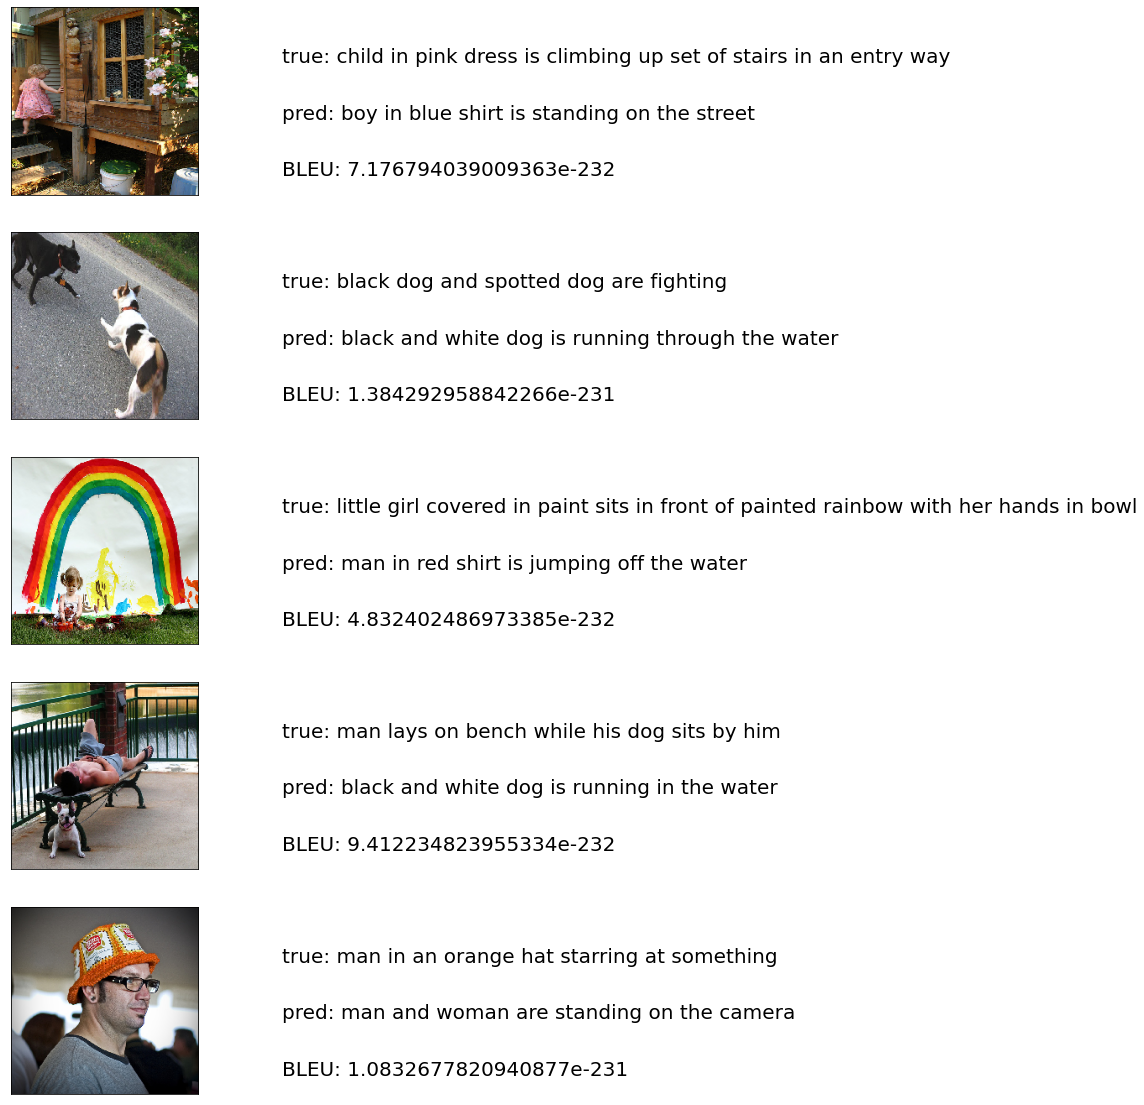

Good Caption


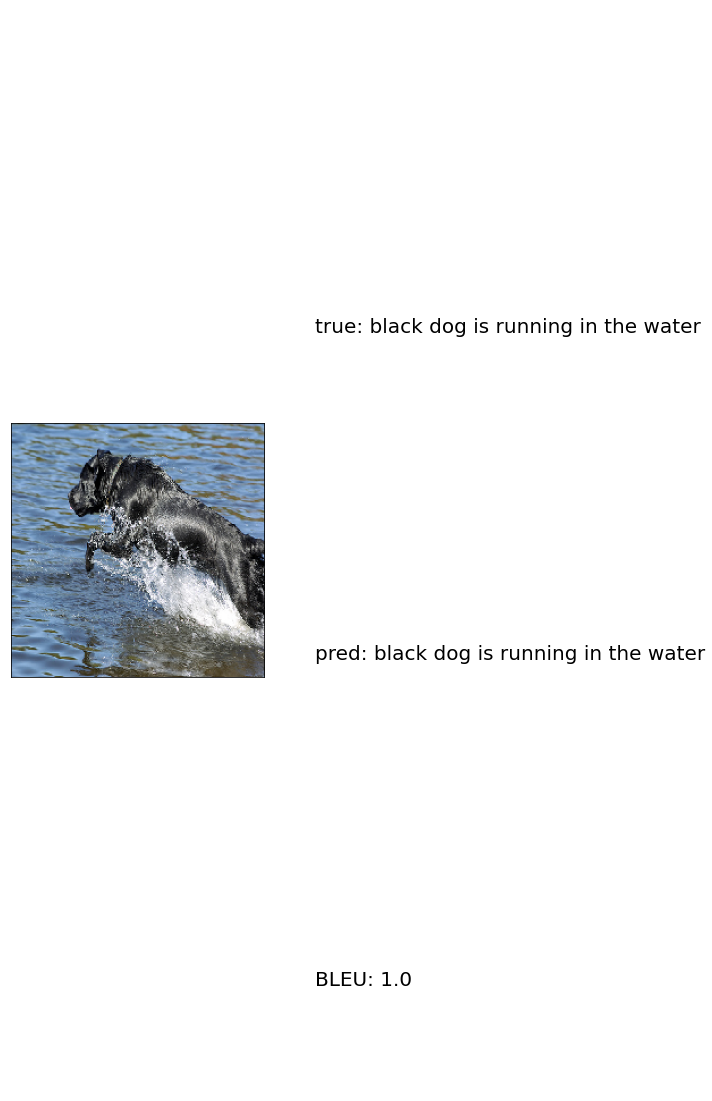

In [45]:

def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)
